# Home Credit Default Risk Analysis 
*Dimitar Vlassarev 2018*

# Imports and Data Loading

## Load Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [95]:
# Load data into dataframes
application_train     = pd.read_csv(r"data/application_train.csv.zip")
# application_test      = pd.read_csv(r"data/application_test.csv.zip")
# bureau                = pd.read_csv(r"data/bureau.csv.zip")
# bureau_balance        = pd.read_csv(r"data/bureau_balance.csv.zip")
# credit_card_balance   = pd.read_csv(r"data/credit_card_balance.csv.zip")
# installments_payments = pd.read_csv(r"data/installments_payments.csv.zip")
# pos_cash_balance      = pd.read_csv(r"data/POS_CASH_balance.csv.zip")
# previous_application  = pd.read_csv(r"data/previous_application.csv.zip")
columns_description   = pd.read_csv(r"data/HomeCredit_columns_description.csv", encoding='cp1252')

## Display Column descriptions

In [86]:
# Column descriptions
pd.options.display.max_rows = 500
display(columns_description[["Table", "Row", "Description", "Special"]])
pd.reset_option("max_rows")

,Table,Row,Description,Special
0,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [97]:
# Pick out string columns
cardinal_columns = application_train.select_dtypes([np.object]).columns
for col_name in cardinal_columns:
    col_data = application_train[col_name]
    print("{:28s} has {:2d} levels.".format(col_name, len(col_data.unique())))

# One-hot encode all the cardinal columns
def clean_col_name(name):
    """
        Cleans column names from special characters and whitespaces.
        Args:
            name (str): Input name
        Returns:
            name (str): Cleaned up name
    """
    
    name = name.upper()
    name = name.replace(",", "_")
    name = name.replace(" ", "_")
    name = name.replace("/", "_")
    name = name.replace(":", "_")
    return(name)

for col_name in cardinal_columns:
    dummy_cols = pd.get_dummies(application_train[col_name])
    dummy_cols.columns = ["{}_{}".format(col_name, clean_col_name(dummy_name)) for dummy_name in dummy_cols]
              
    application_train = application_train.merge(
        dummy_cols,
        left_index=True,
        right_index=True)
    application_train = application_train.drop(col_name, axis=1)

In [99]:
application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_TERRACED_HOUSE,WALLSMATERIAL_MODE_BLOCK,WALLSMATERIAL_MODE_MIXED,WALLSMATERIAL_MODE_MONOLITHIC,WALLSMATERIAL_MODE_OTHERS,WALLSMATERIAL_MODE_PANEL,WALLSMATERIAL_MODE_STONE__BRICK,WALLSMATERIAL_MODE_WOODEN,EMERGENCYSTATE_MODE_NO,EMERGENCYSTATE_MODE_YES
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.003941,0.030090,0.007466,0.005785,0.005284,0.214757,0.210773,0.017437,0.518446,0.007570
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.062656,0.170835,0.086085,0.075840,0.072501,0.410654,0.407858,0.130892,0.499660,0.086679
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [98]:
for col in application_train.columns:
    print(col)

SK_ID_CURR
TARGET
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVIN

In [31]:
# Target data appears to be all present and only contain 0 and 1 values
y = application_train["TARGET"].copy()

In [15]:
application_train["EXT_SOURCE_1"].describe()

count    134133.000000
mean          0.502130
std           0.211062
min           0.014568
25%           0.334007
50%           0.505998
75%           0.675053
max           0.962693
Name: EXT_SOURCE_1, dtype: float64

In [13]:
application_train[["NAME_CONTRACT_TYPE"]].merge(
    pd.get_dummies(application_train["NAME_CONTRACT_TYPE"]),
    left_index=True,
    right_index=True)

,NAME_CONTRACT_TYPE,Cash loans,Revolving loans
0,Cash loans,1,0
1,Cash loans,1,0
2,Revolving loans,0,1
3,Cash loans,1,0
4,Cash loans,1,0
5,Cash loans,1,0
6,Cash loans,1,0
7,Cash loans,1,0
8,Cash loans,1,0
9,Revolving loans,0,1


In [32]:
X = application_train[["CNT_CHILDREN", 
                  "AMT_INCOME_TOTAL",
                  "AMT_CREDIT",
                  "AMT_ANNUITY",
                  "AMT_GOODS_PRICE",
                  "DAYS_BIRTH",
                  "DAYS_EMPLOYED"]].copy()

In [33]:
mask = X.isna().apply(lambda row: not any(row), axis=1)

In [34]:
X = X[mask].values
y = y[mask].values

In [43]:
pca = PCA(n_components=2)
pca_model = pca.fit(X)

In [44]:
X_pca = pca_model.transform(X)

In [45]:
# Print the number of features
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_pca.shape[1])

Original number of features: 7
Reduced number of features: 2


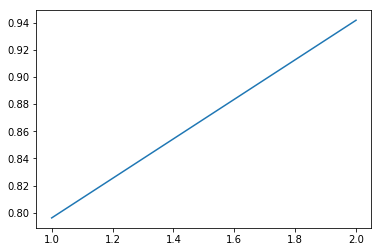

In [47]:
plt.plot(range(1, X_pca.shape[1] + 1), np.cumsum(pca.explained_variance_ratio_))